In [4]:
import networkx as nx
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *

########### set random state
np.random.seed(297)

In [7]:
# load train/test data
load_dir = '../data/processed'
Xtrain, Xtest, Ytrain, Ytest = load_datasets(load_dir)

# load jared model predictions
jared_train_pred = pd.read_csv(f'{load_dir}/predictions/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv(f'{load_dir}/predictions/jared_test_yhat.csv').values

# load distance data
dis_path = '../data/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)
dis_data = distances['road_distances']
dis_data[dis_data==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0
dis_key_map = distances['idx2pid'].item()
dis_key_map_inv = dict(zip(dis_key_map.values(), dis_key_map.keys()))

def get_parcel_index(_parcel):
    try:
        return dis_key_map_inv[_parcel]
    except KeyError:
        pass

# build distance matrices
train_indices = [get_parcel_index(_parcel) for _parcel in Ytrain.pid.values if get_parcel_index(_parcel) is not None]
test_indices = [get_parcel_index(_parcel) for _parcel in Ytest.pid.values if get_parcel_index(_parcel) is not None]
train_distances = dis_data[train_indices,:][:,train_indices]
test_distances = dis_data[test_indices,:][:,test_indices]

print("done")

done


In [8]:
#build subgraph
n_subgraph = 20
subgraph = test_distances[:n_subgraph,:n_subgraph]

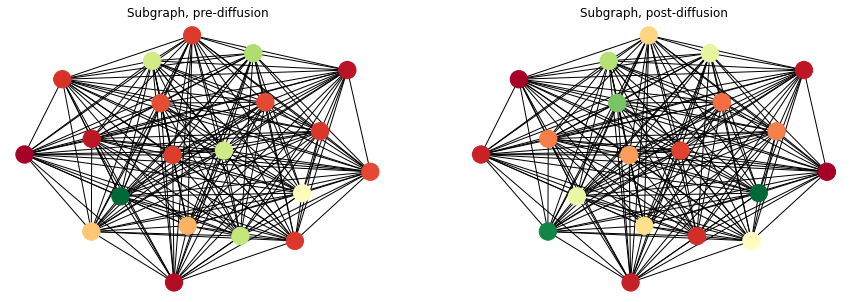

In [19]:
def diffusion(subgraph):

    g = nx.from_numpy_array(subgraph)
    pos = nx.spring_layout(g)

    subgraph_pre_diffusion_probs = jared_test_pred[:n_subgraph,1]

    nn = NearestNeighbors(n_neighbors=2, metric='precomputed')
    nn.fit(subgraph)

    neighbor_distances, neighbor_indices = nn.kneighbors()
    
    # UPDATE THIS LINE TO CHANGE HOW THE DISTANCE INFLUENCES THE WEIGHT
    neighbor_weights = 1/(1 + neighbor_distances)

    
    # UPDATE THIS LINE TO CHANGE HOW WE INCORPORATE NEIGHBOR PROBABILITIES
    outputs = np.average(subgraph_pre_diffusion_probs[neighbor_indices], axis=1, weights = neighbor_weights)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    nx.draw(g, pos, node_color=1-subgraph_pre_diffusion_probs, cmap = cm.RdYlGn, ax=ax[0])
    ax[0].set_title('Subgraph, pre-diffusion')
    #plt.show()

    nx.draw(g, pos, node_color=1-outputs, cmap = cm.RdYlGn, ax=ax[1])
    ax[1].set_title('Subgraph, post-diffusion')
    
    
    plt.show()
    
diffusion(subgraph)

# big problems
# consistent color scale